In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import os
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tqdm import tqdm

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 16, 10

RANDOM_SEED = 72

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [3]:
# Set only one GPU device to be visibile: comment if there are not multiple GPUs
os.environ["CUDA_VISIBLE_DEVICES"]="4" 

# Temperature time-series forecasting with Recurrent Neural Networks

With this notebook, we are going to show an application of Recurrent Neural Networks (RNN) for time-series forecasting. The case study is the prediction of weekly temperatures in Bologna, with the data extracted from here: https://www.ecad.eu/dailydata/customquery.php . Temperatures are highly periodical, so they are much more easy to predict than other time-series. In fact, time-series forecasting with deep learning is useful when you have to learn recurrent patterns over time, but it's prone to fail when unobserved interactions from outside modify the system. By unconmmenting the commented cell, you can try to predict COVID19 new cases in Italy, that is much more complex.

First, we are going to collect and prepare the data. We will try first the one-step prediction approach, which means predicting the next week avergage temperature given the past weeks temperatures. Then, we will move to the multi-step approach, which tries to predict future temperature values for multiple weeks simultaneously. Finally, we will show how to easily switch from a simple RNN to a Long Short-Term Memory neural network (LSTM).

## Data preparation

Use this cell to predict COVID time-series in Italy, which are daily updated daily by Protezione Civile. Also data regarding vaccinations is available in another repository.

In [56]:
### COVID19

#data_vax=pd.read_csv('https://raw.githubusercontent.com/italia/covid19-opendata-vaccini/master/dati/somministrazioni-vaccini-summary-latest.csv')
#data_vax['data_somministrazione']=pd.to_datetime(data_vax.data_somministrazione).dt.date
#data_vax=data_vax.groupby('data_somministrazione')['seconda_dose'].sum().cumsum()
#data_vax.reindex(pd.to_datetime(data_vax.index))
#data=pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv')
#data.set_index(pd.to_datetime(data.data).dt.date,inplace=True,drop=True)
#data.drop(['data','stato','casi_da_sospetto_diagnostico','note',
#           'tamponi','casi_testati','casi_da_screening',
#           'variazione_totale_positivi','note_casi','note_test',
#          'tamponi_test_molecolare','tamponi_test_antigenico_rapido','dimessi_guariti'],axis=1,inplace=True)
#data.dropna(axis='columns',inplace=True)
#print(data.shape)

# Merge together infections data and vaccine data
#data=data.merge(data_vax,how='outer',left_index=True,right_index=True)
#print(data.shape)

#data.fillna(0,inplace=True)
#print(data.columns)

In [4]:
### Bologna weekly temperature

data=pd.read_csv('data/TG_STAID017539.txt',sep=',')
data.columns=['STAT_ID','DATE','TG','Q_TG']
data['DATE']=pd.to_datetime(data['DATE'],format='%Y%m%d',errors='raise')
data=data[data.DATE<=pd.to_datetime('2018-12-31')]
data.set_index('DATE',inplace=True)
data.loc[data.Q_TG!=0,'TG']=np.nan
data['TG']=data.TG/10
data['Temperature']=data['TG'].interpolate('linear')
data.dropna(subset=['Temperature'],inplace=True)
data=data[['TG','Temperature']].resample('W').mean()
data

,TG,Temperature
DATE,,
2006-01-01,0.000000,0.000000
2006-01-08,4.314286,4.314286
2006-01-15,2.185714,2.185714
2006-01-22,1.000000,1.000000
2006-01-29,0.928571,0.928571
...,...,...
2018-12-09,8.200000,8.200000
2018-12-16,4.614286,4.614286
2018-12-23,2.500000,2.500000


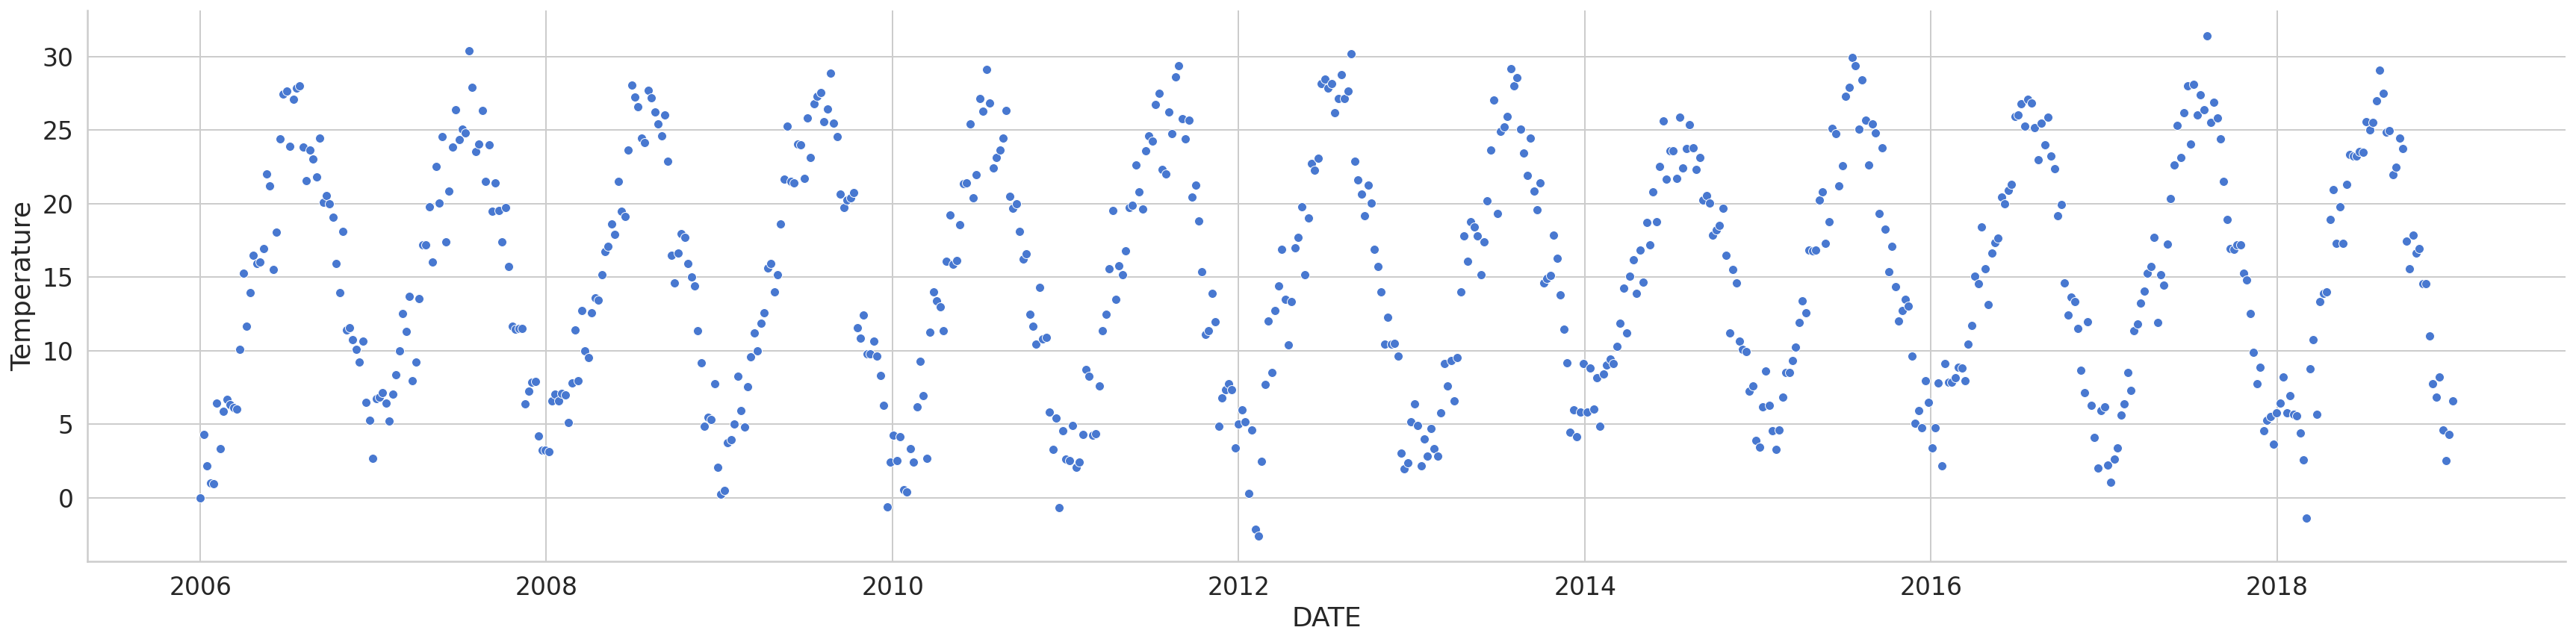

In [5]:
#Data inspection
g=sns.relplot(data=data['Temperature'],height=6,aspect=4)

Our goal will be to predict the future weekly temperatures, given the observed values in the past 10 weeks. 

Adding more columns to the DataFrame, one should also be able to use multiple parallel time series (precipitations, humidity...) as a multivariate input to predict the future temperatures. In this notebook, we are using only the past temperatures (univariate time-series).

As a first step, we are applying a moving average with a window of 4 weeks to smooth out the curve. This operation removes some noise, so that the RNN can focus to learn the global trends.

In [6]:
window_len=4
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

# N.B. Appliying the moving average will remove the first and last windows//2 days from the dataset.
data_avg=data.iloc[window_len//2-1:-window_len//2].copy()
for col in data.columns:
    data_avg[col]=moving_average(data[col],window_len)

We standardize the data, that makes it more easy for the RNN to train with default hyperparameters.

In [7]:
#scaler = MinMaxScaler(feature_range=(0, 1))
scaler = StandardScaler()
scaled = scaler.fit_transform(data_avg.values)
data_scaled=pd.DataFrame(scaled,columns=data_avg.columns)

We prepare a function to rearrange the dataset into a supervised learning formar, by "unrolling" the time series. Each observation in X will contain _time\_steps_ past temperature values to be used as input to predict the temperature y of the next *next\_steps* weeks.

In [8]:
def create_dataset(X, y, time_steps=1,next_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps-next_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps: i+time_steps+next_steps])
    return np.array(Xs), np.array(ys)

## One-step forecasting

In [9]:
time_steps = 10
next_steps=1

train_size = int(len(data_scaled) * 0.84)
test_size = len(data_scaled) - train_size
train, test = data_scaled.iloc[0:train_size], data_scaled.iloc[train_size-time_steps-next_steps:len(data_scaled)]
print(len(train), len(test))

568 120


In [10]:
# reshape to [samples, time_steps, n_features]

#X_train, y_train = create_dataset(train[['nuovi_positivi']], train.nuovi_positivi, time_steps,next_steps)
#X_test, y_test = create_dataset(test[['nuovi_positivi']], test.nuovi_positivi, time_steps,next_steps)
X_train, y_train = create_dataset(train[['Temperature']], train.Temperature, time_steps,next_steps)
X_test, y_test = create_dataset(test[['Temperature']], test.Temperature, time_steps,next_steps)

print(X_train.shape, y_train.shape)

(557, 10, 1) (557, 1)


In [11]:
X_train[0]

array([[-1.72559392],
       [-1.69548298],
       [-1.62692269],
       [-1.59032632],
       [-1.4323597 ],
       [-1.24659836],
       [-1.24984108],
       [-1.15950826],
       [-1.15441256],
       [-1.04369696]])

In [12]:
y_train[0]

array([-0.75463194])

In [13]:
X_train.shape

(557, 10, 1)

In [15]:
model = keras.Sequential()
model.add(keras.layers.SimpleRNN(1,activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
#model.add(keras.layers.Dense(64, activation='relu'))
#model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(next_steps))
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(0.001))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 1)                 3         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


In [16]:
%%time
history = model.fit(
    X_train, y_train, 
    epochs=100, 
    batch_size=16, 
    validation_split=0.2, 
    verbose=0, 
    shuffle=False
)

CPU times: user 44.3 s, sys: 3.79 s, total: 48.1 s
Wall time: 26.8 s


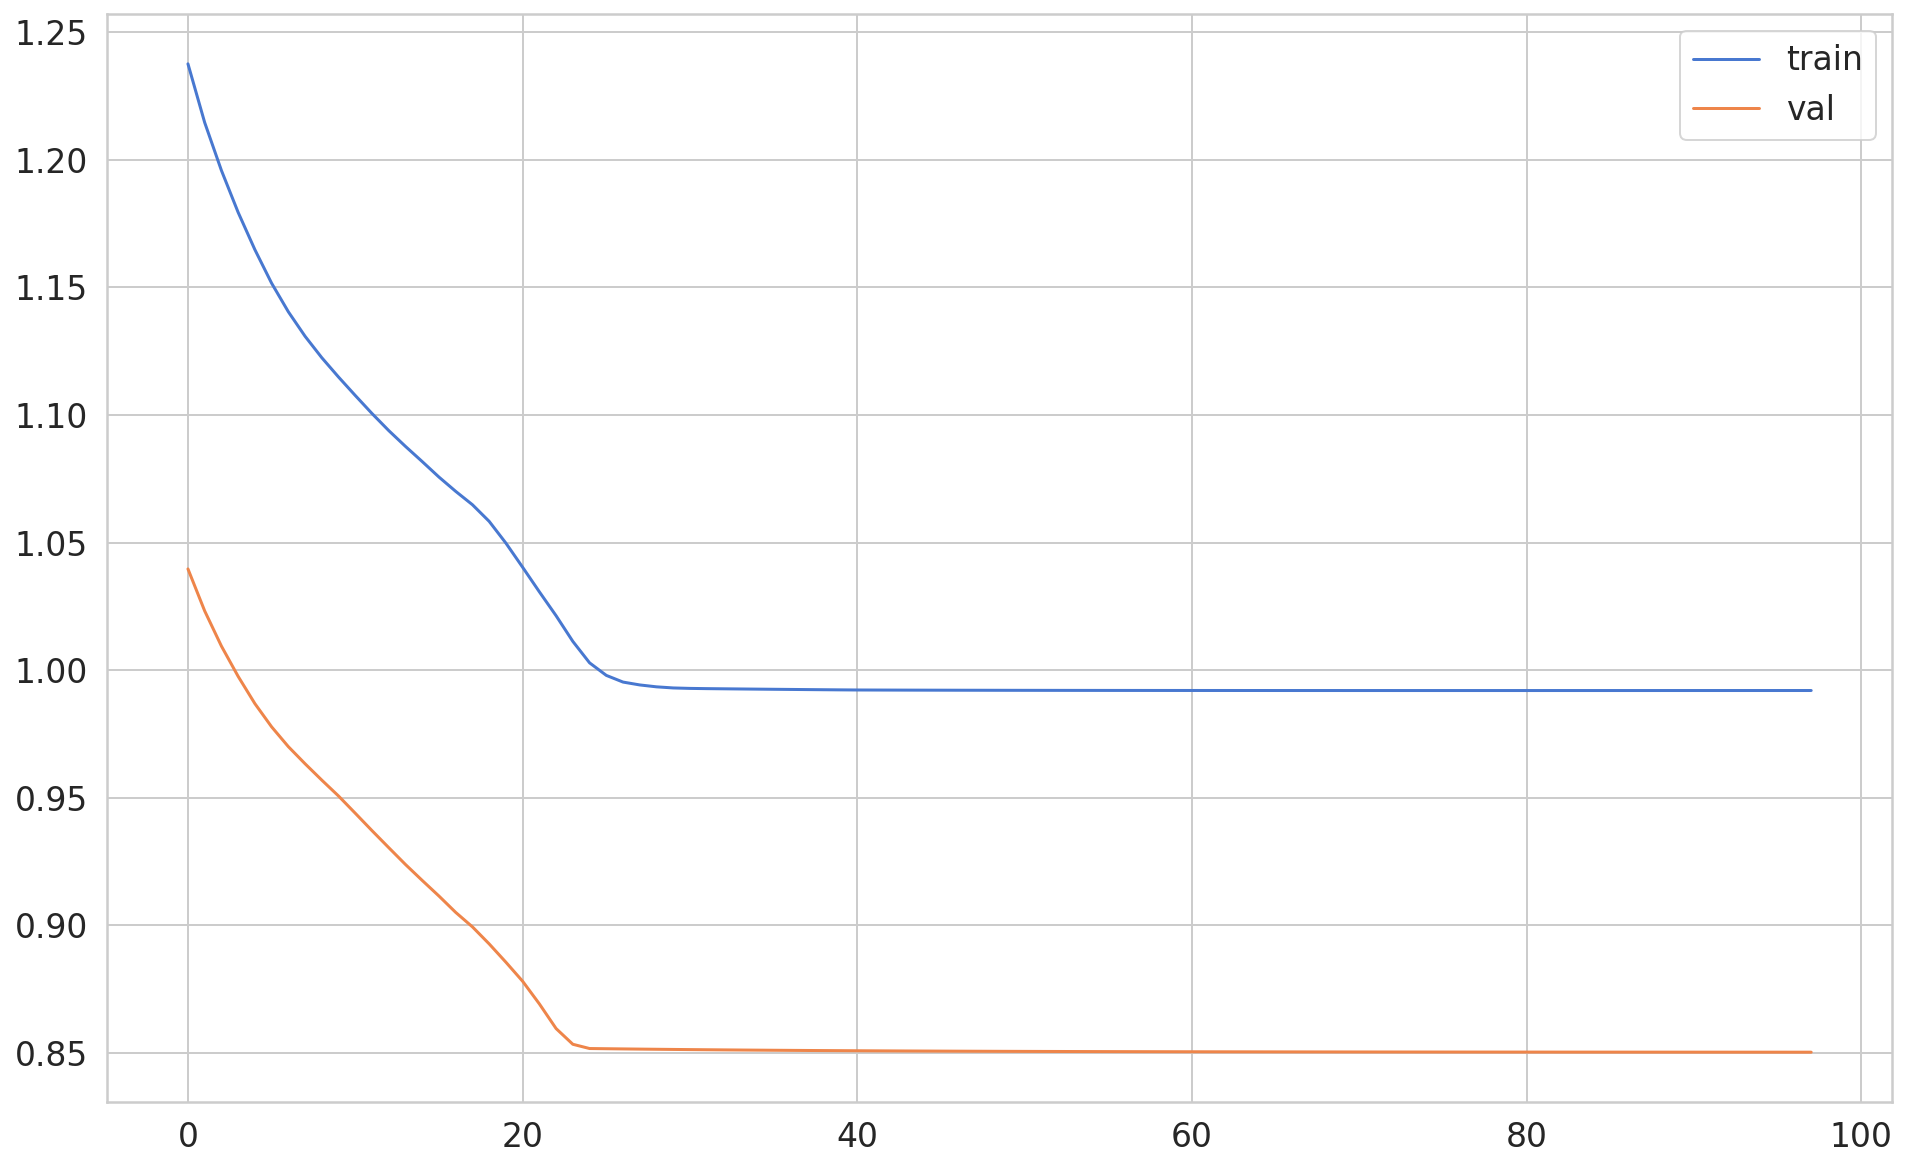

In [17]:
plt.plot(history.history['loss'][2:], label='train')
plt.plot(history.history['val_loss'][2:], label='val')
plt.legend();

In [18]:
X_test[0]

array([[ 0.96956677],
       [ 0.77593027],
       [ 0.49705665],
       [ 0.17510122],
       [-0.00371144],
       [-0.21680424],
       [-0.31732845],
       [-0.4386987 ],
       [-0.65040176],
       [-0.69533655]])

In [18]:
y_test[0]

array([-0.8648843])

In [19]:
model.predict(X_test)[0]

array([0.03009414], dtype=float32)

By calling the _predict_ method of the model, the RNN is sequentially shown the observed data contained in *X\_test* and use them to predict the next week based on the previous 10 weeks. This approach is feasible only in you know the future inputs: we can predict the temperature at t+1, but we cannot predict now the temperature at t+2, beacause we would need t+1 in that case (but **we have not observed** it yet). 

In [21]:
y_pred_test=model.predict(X_test)
print(len(y_pred_test))

109


We can also try to self-feed the RNN, by using the predictions as inputs for the next step. In this way, we can detach from the observed series at the end of the training set and let the time series propagate without limits in the future.

In [22]:
y_selffeed_test=np.array([])
x_input=X_test[0].copy()
for i in tqdm(range(len(y_test)//next_steps+1 )):
    next_pred=model.predict(x_input.reshape(1,x_input.shape[0],x_input.shape[1]))
    y_selffeed_test=np.concatenate([y_selffeed_test, next_pred[0]])
    #print(x_input)
    x_input[:,0]=np.concatenate([x_input[next_steps:,0],next_pred.reshape(-1)])
    for j in range(1,x_input.shape[1]):
        x_input[:,j]=np.concatenate([x_input[next_steps:,j],X_test[i+1,:next_steps,j]])

100%|██████████| 110/110 [00:05<00:00, 21.94it/s]


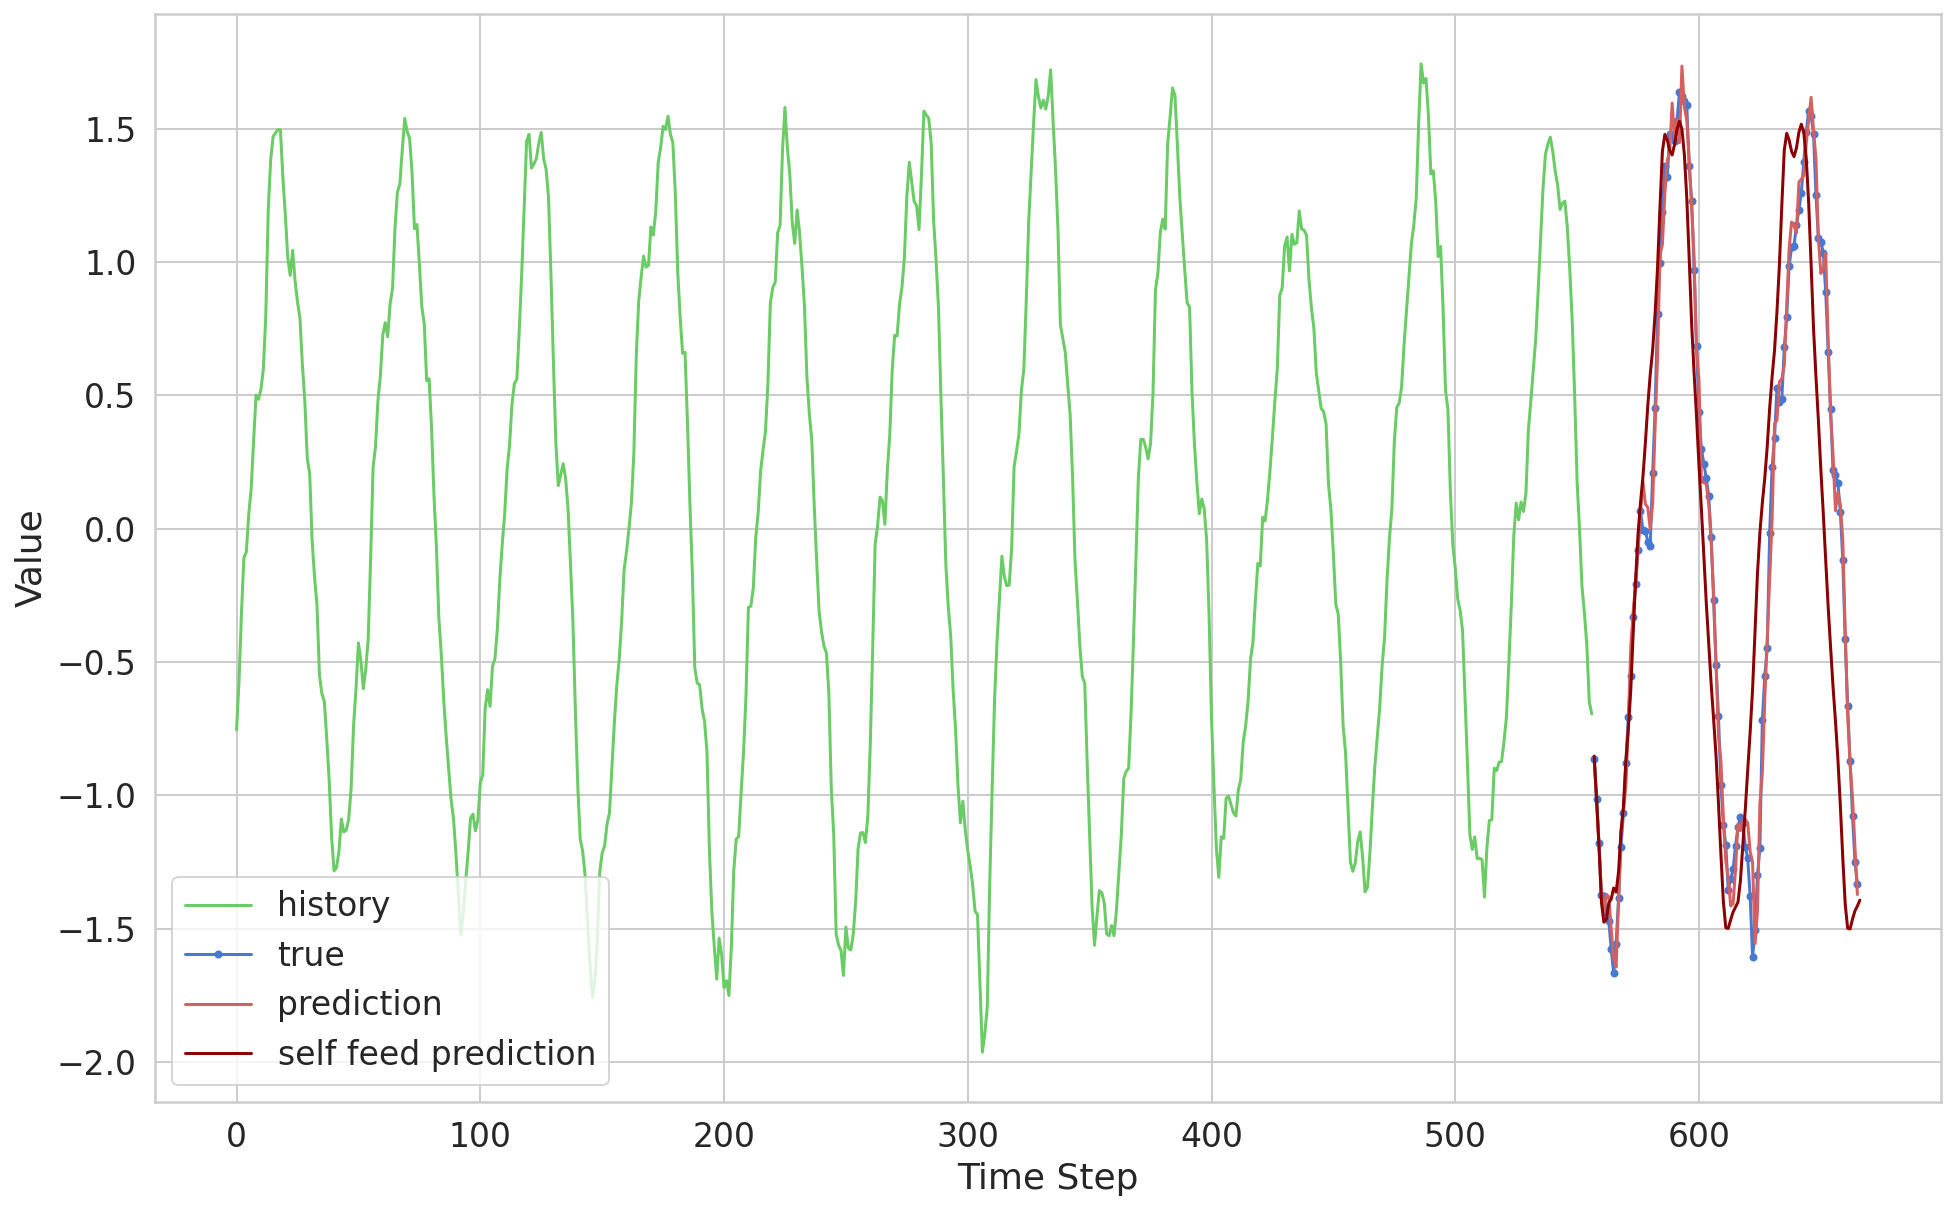

In [23]:
plt.plot(np.arange(0, len(y_train)), [el[0] for el in y_train], 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), [el[0] for el in y_test], marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_test, 'r', label="prediction")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_selffeed_test)), y_selffeed_test, 'darkred', label="self feed prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [24]:
# Test RMSE
np.sqrt(np.mean((y_test-np.array(y_pred_test))**2))

0.09077430630059843

In [25]:
# Test RMSE of self-fed predictions
np.sqrt(np.mean((y_test-y_selffeed_test[:len(y_pred_test)])**2))

1.4874092403479966

## Multi-step forecasting

Multi-step forecasting means that our goal is now to predict the multiple next weeks simultaneously. In particular, we want to predict the weekly temperatures of the next month, so now each observation in X will have a corresponding 4-dimensional output to be predicted.

In [26]:
time_steps = 10
next_steps=4

train_size = int(len(data_scaled) * 0.84)
test_size = len(data_scaled) - train_size
train, test = data_scaled.iloc[0:train_size], data_scaled.iloc[train_size-time_steps-next_steps:len(data_scaled)]
print(len(train), len(test))

568 123


In [27]:
# reshape to [samples, time_steps, n_features]

#X_train, y_train = create_dataset(train[['nuovi_positivi']], train.nuovi_positivi, time_steps,next_steps)
#X_test, y_test = create_dataset(test[['nuovi_positivi']], test.nuovi_positivi, time_steps,next_steps)
X_train, y_train = create_dataset(train[['Temperature']], train.Temperature, time_steps,next_steps)
X_test, y_test = create_dataset(test[['Temperature']], test.Temperature, time_steps,next_steps)

print(X_train.shape, y_train.shape)

(554, 10, 1) (554, 4)


In [28]:
X_train[0]

array([[-1.72559392],
       [-1.69548298],
       [-1.62692269],
       [-1.59032632],
       [-1.4323597 ],
       [-1.24659836],
       [-1.24984108],
       [-1.15950826],
       [-1.15441256],
       [-1.04369696]])

In [29]:
y_train[0]

array([-0.75463194, -0.5739663 , -0.3177917 , -0.11025784])

In [30]:
X_train.shape

(554, 10, 1)

In [31]:
model = keras.Sequential()
model.add(keras.layers.SimpleRNN(64, activation='relu',input_shape=(X_train.shape[1], X_train.shape[2])))
#model.add(keras.layers.Dense(64, activation='relu'))
#model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(next_steps))
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(0.001))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 64)                4224      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 260       
Total params: 4,484
Trainable params: 4,484
Non-trainable params: 0
_________________________________________________________________


In [32]:
%%time
history = model.fit(
    X_train, y_train, 
    epochs=100, 
    batch_size=16, 
    validation_split=0.2, 
    verbose=0, 
    shuffle=False
)

CPU times: user 47.9 s, sys: 5.11 s, total: 53.1 s
Wall time: 28.5 s


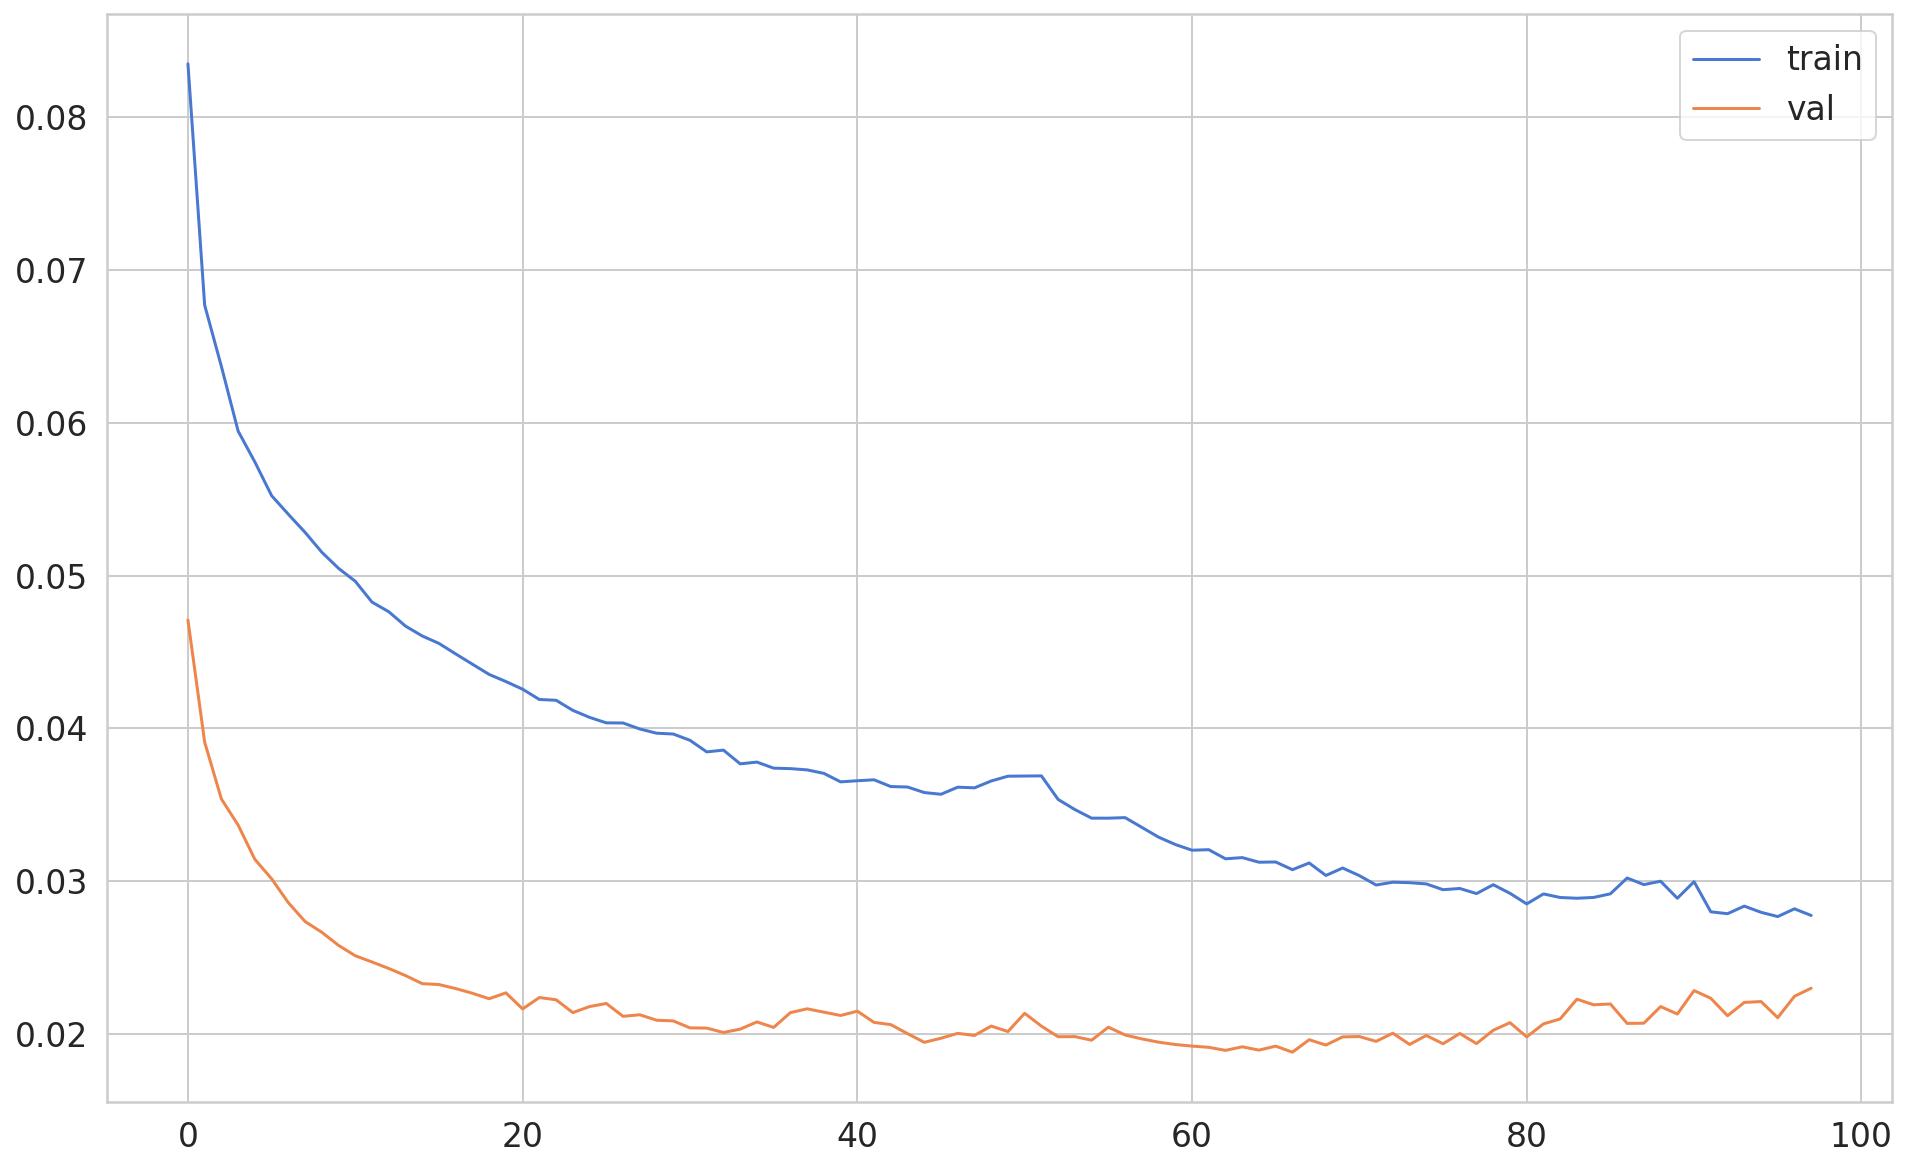

In [33]:
plt.plot(history.history['loss'][2:], label='train')
plt.plot(history.history['val_loss'][2:], label='val')
plt.legend();

In [34]:
X_test[0]

array([[ 1.22018244],
       [ 1.22759436],
       [ 1.12614366],
       [ 0.96956677],
       [ 0.77593027],
       [ 0.49705665],
       [ 0.17510122],
       [-0.00371144],
       [-0.21680424],
       [-0.31732845]])

In [35]:
y_test[0]

array([-0.4386987 , -0.65040176, -0.69533655, -0.8648843 ])

In [36]:
model.predict(X_test)[0]

array([-0.4657084 , -0.56823903, -0.8320697 , -1.0304286 ], dtype=float32)

In *y\_pred\_test* we put the predictions made using real data from *X\_text*, with a shift of *next\_steps* between each prediction.

In *y\_selffeed\_test* we let the prediction self-propagate as we did in the section above.

In [37]:
y_pred_test=np.array([])
x_input=X_test[0].copy()
for i in range(len(y_test)//next_steps ):
    next_pred=model.predict(x_input.reshape(1,x_input.shape[0],x_input.shape[1]))
    y_pred_test=np.concatenate([y_pred_test, next_pred[0]])
    if len(y_pred_test)>=len(y_test):
        break
    x_input=X_test[(i+1)*next_steps].copy()

In [38]:
len(y_pred_test)

108

In [39]:
y_selffeed_test=np.array([])
x_input=X_test[0].copy()
for i in range(len(y_test)//next_steps+1 ):
    next_pred=model.predict(x_input.reshape(1,x_input.shape[0],x_input.shape[1]))
    y_selffeed_test=np.concatenate([y_selffeed_test, next_pred[0]])
    #print(x_input)
    x_input[:,0]=np.concatenate([x_input[next_steps:,0],next_pred.reshape(-1)])
    for j in range(1,x_input.shape[1]):
        x_input[:,j]=np.concatenate([x_input[next_steps:,j],X_test[i+1,:next_steps,j]])

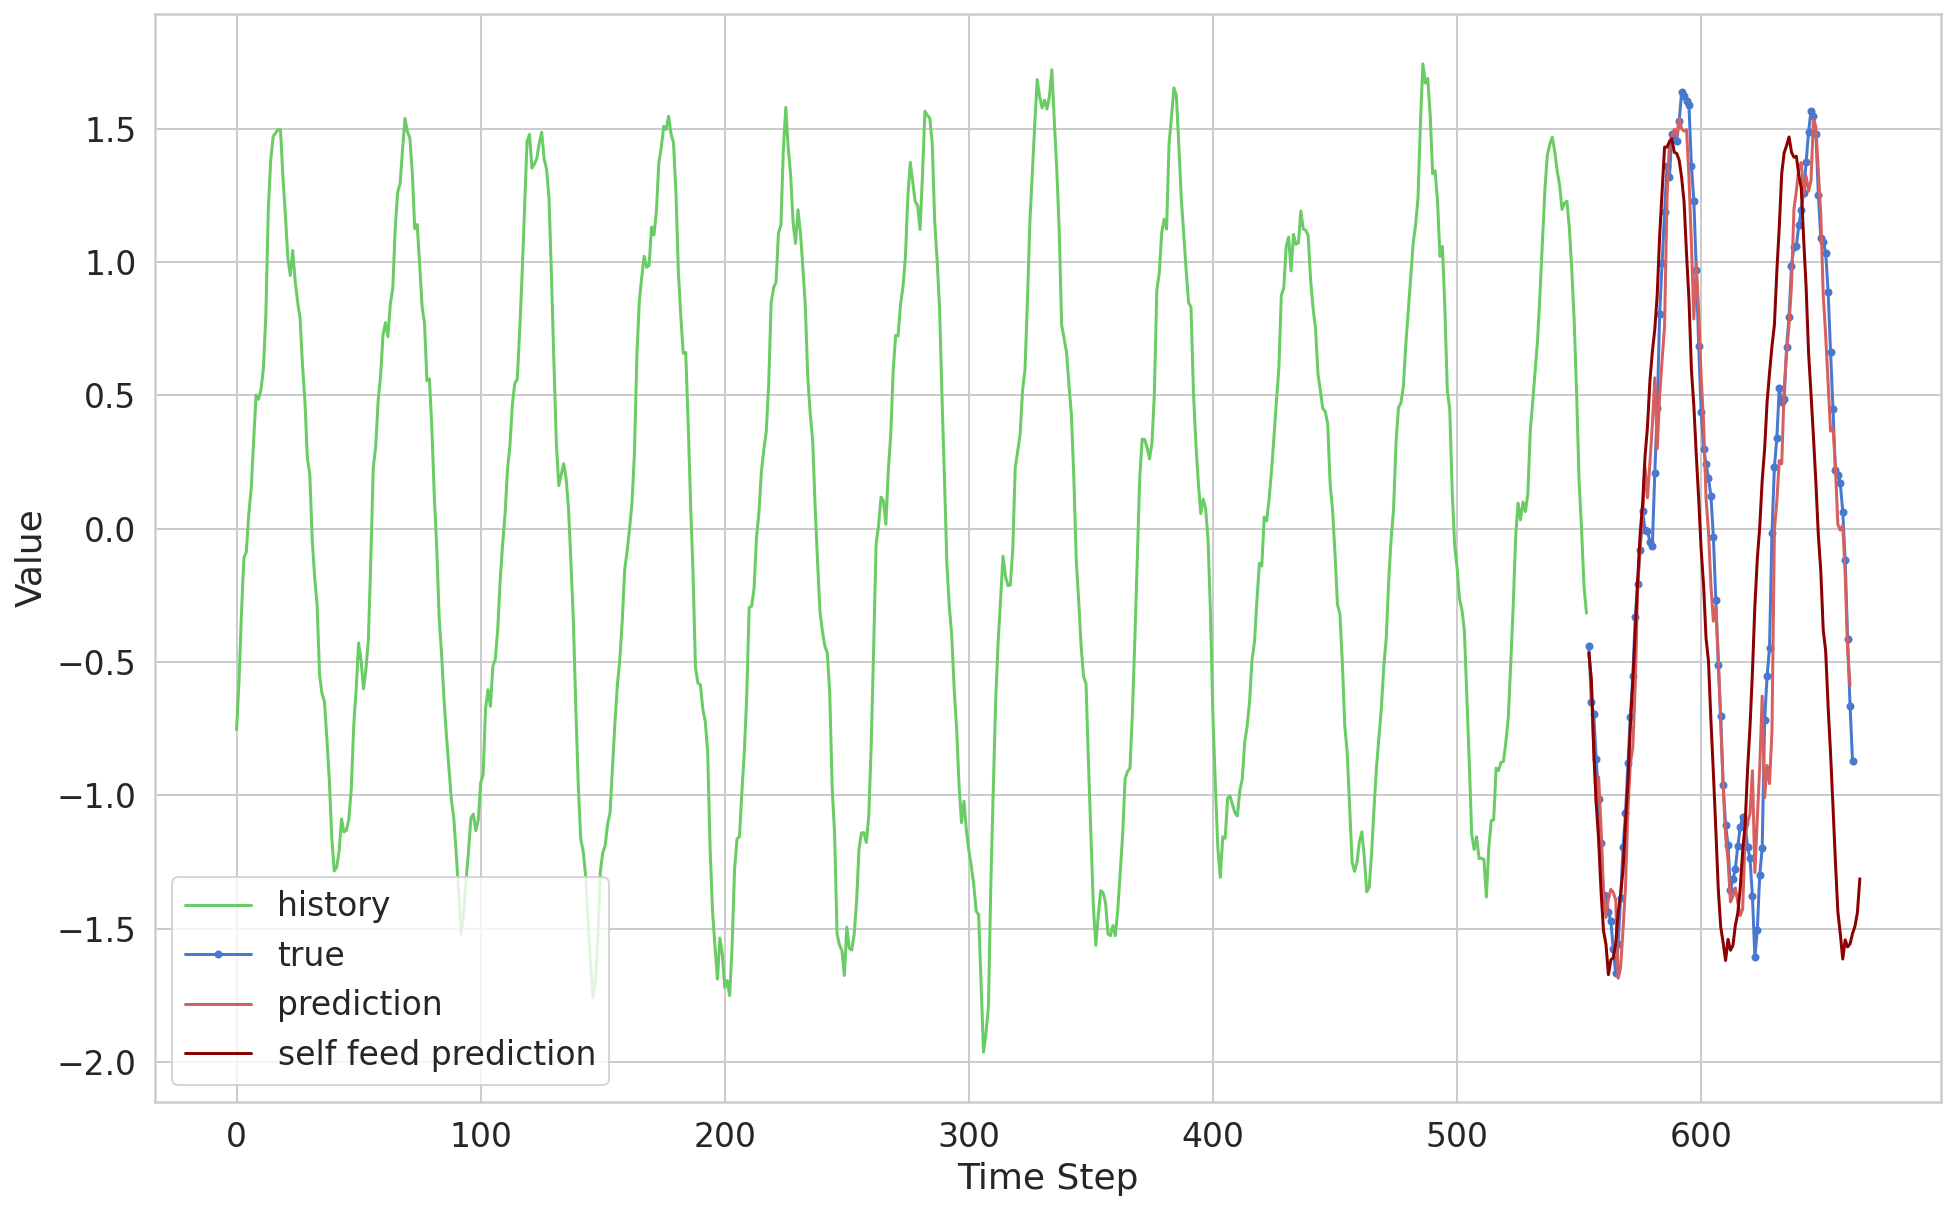

In [40]:
plt.plot(np.arange(0, len(y_train)), [el[0] for el in y_train], 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), [el[0] for el in y_test], marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_pred_test)), y_pred_test, 'r', label="prediction")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_selffeed_test)), y_selffeed_test, 'darkred', label="self feed prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

Test RMSE that uses real data as inputs is lower than the one-step RMSE because the task of predictin 4 weeks instead of 1 is more difficult in general.

The self-fed predictions RMSE is improved because now we are forcing the network to forecast a longer time period.

In [41]:
#Test RMSE
np.sqrt(np.mean((np.array([el[0] for el in y_test])[:len(y_pred_test)]-y_pred_test)**2))

0.22787478982807888

In [42]:
#Self-fed test RMSE
np.sqrt(np.mean((np.array([el[0] for el in y_test])-y_selffeed_test[:len(y_test)])**2))

0.75461301961773

### LSTM network

Just as an example, one could modify the network architecture adding multiple layers, dropouts, and so on... Te structure of simple Recurrent Neural Networks focus more on the last inputs in temporal order. To overcome this possible limitation, RNNs are very often enriched by Long Short-Term Memory cells, that sould help the network to focus also to inputs more far away in the past, adding a "longer short-term memory" to the model.

In [43]:
model = keras.Sequential()
model.add(keras.layers.LSTM(64, activation='relu',input_shape=(X_train.shape[1], X_train.shape[2]),dropout=0.2, return_sequences=False))
#model.add(keras.layers.Dense(16))
model.add(keras.layers.Dense(next_steps))
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(0.001))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 260       
Total params: 17,156
Trainable params: 17,156
Non-trainable params: 0
_________________________________________________________________


In [44]:
%%time
history = model.fit(
    X_train, y_train, 
    epochs=100, 
    batch_size=16, 
    validation_split=0.2, 
    verbose=0, 
    shuffle=False
)

CPU times: user 1min 41s, sys: 11.8 s, total: 1min 53s
Wall time: 51.9 s


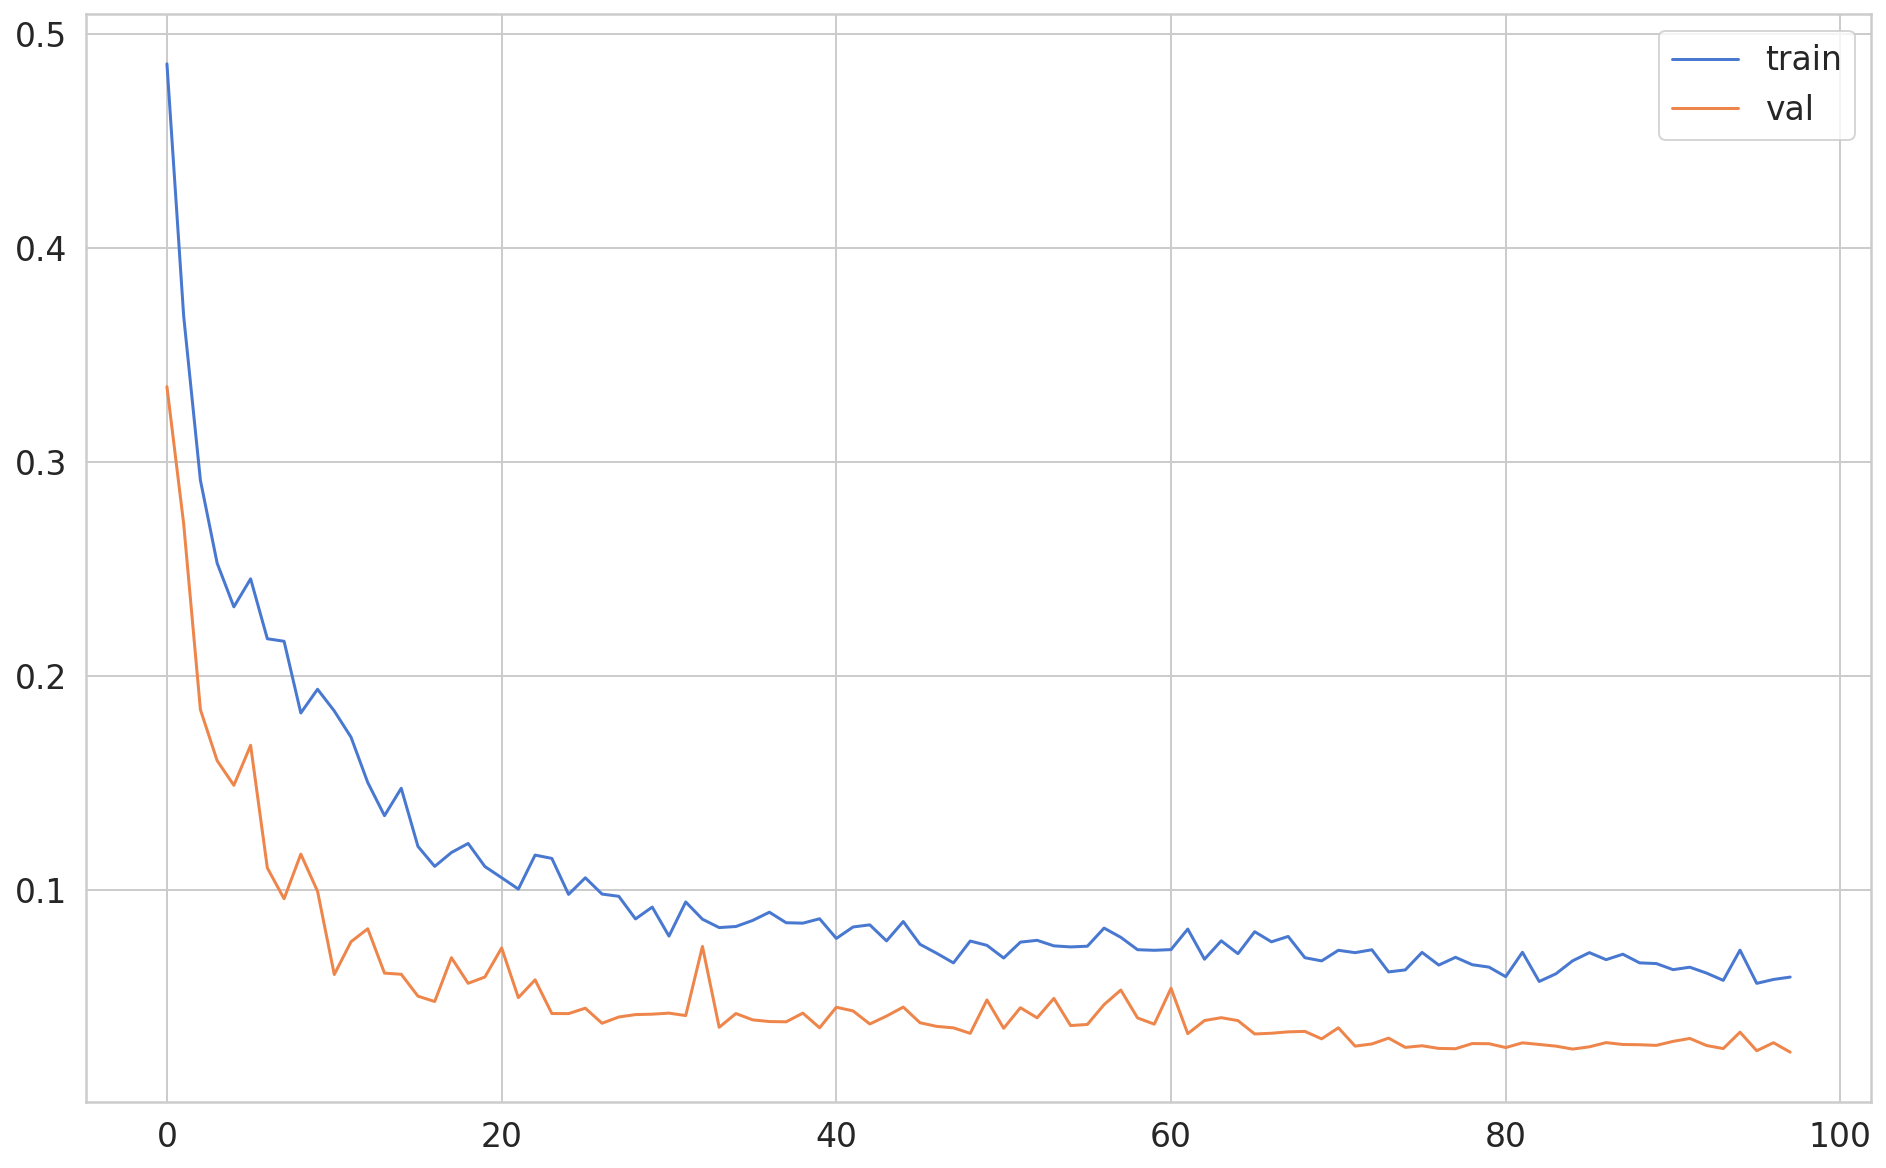

In [45]:
plt.plot(history.history['loss'][2:], label='train')
plt.plot(history.history['val_loss'][2:], label='val')
plt.legend();

In [46]:
X_test[0]

array([[ 1.22018244],
       [ 1.22759436],
       [ 1.12614366],
       [ 0.96956677],
       [ 0.77593027],
       [ 0.49705665],
       [ 0.17510122],
       [-0.00371144],
       [-0.21680424],
       [-0.31732845]])

In [47]:
model.predict(X_test)[0]

array([-0.4702855, -0.6320097, -0.8004899, -0.9396832], dtype=float32)

In [48]:
y_test[0]

array([-0.4386987 , -0.65040176, -0.69533655, -0.8648843 ])

In [49]:
y_pred_test=np.array([])
x_input=X_test[0].copy()
for i in range(len(y_test)//next_steps ):
    next_pred=model.predict(x_input.reshape(1,x_input.shape[0],x_input.shape[1]))
    y_pred_test=np.concatenate([y_pred_test, next_pred[0]])
    if len(y_pred_test)>=len(y_test):
        break
    x_input=X_test[(i+1)*next_steps].copy()

In [50]:
len(y_pred_test)

108

In [51]:
y_selffeed_test=np.array([])
x_input=X_test[0].copy()
for i in range(len(y_test)//next_steps+1 ):
    next_pred=model.predict(x_input.reshape(1,x_input.shape[0],x_input.shape[1]))
    y_selffeed_test=np.concatenate([y_selffeed_test, next_pred[0]])
    #print(x_input)
    x_input[:,0]=np.concatenate([x_input[next_steps:,0],next_pred.reshape(-1)])
    for j in range(1,x_input.shape[1]):
        x_input[:,j]=np.concatenate([x_input[next_steps:,j],X_test[i+1,:next_steps,j]])

In [52]:
len(y_selffeed_test)

112

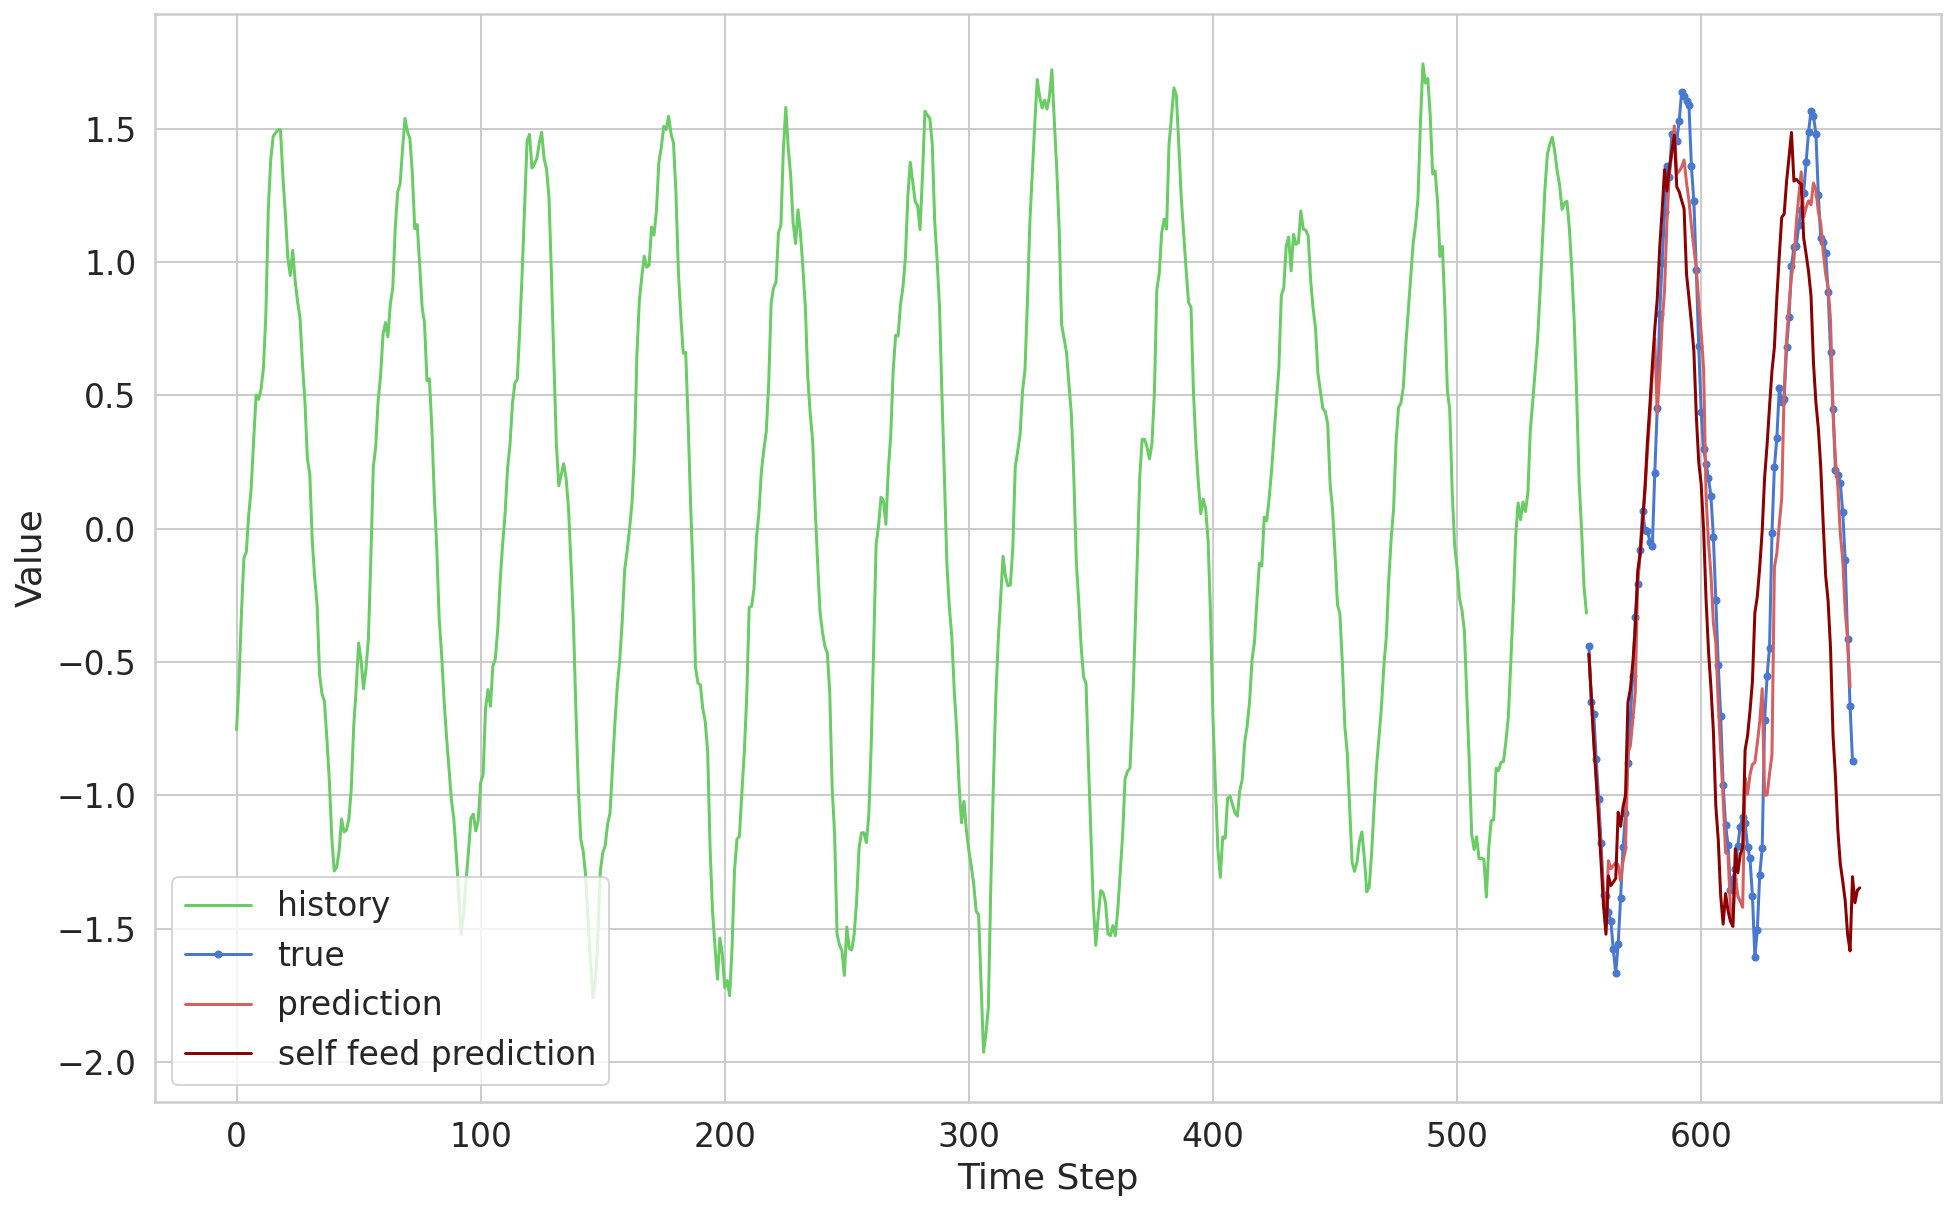

In [53]:
plt.plot(np.arange(0, len(y_train)), [el[0] for el in y_train], 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), [el[0] for el in y_test], marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_pred_test)), y_pred_test, 'r', label="prediction")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_selffeed_test)), y_selffeed_test, 'darkred', label="self feed prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [54]:
#Test RMSE
np.sqrt(np.mean((np.array([el[0] for el in y_test])[:len(y_pred_test)]-y_pred_test)**2))

0.2672387192737887

In [55]:
#Self-fed test RMSE
np.sqrt(np.mean((np.array([el[0] for el in y_test])-y_selffeed_test[:len(y_test)])**2))

0.6296909839077027